# Project 4: Gene regulatory Inferrence With GENIE3

#### Modules used for the project

In [8]:
from sklearn.tree import BaseDecisionTree
from sklearn.ensemble import *
from sklearn.metrics import *
from numpy import *
import time
from operator import itemgetter
from multiprocessing import Pool
import igraph
import os 
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import *
import plotly

#Packages Tested
from tqdm.autonotebook import tqdm
from grenadine.Inference.regression_predictors import *
from grenadine.Inference.inference import *
from grenadine.Preprocessing.standard_preprocessing import *
from sklearn.svm import SVR
import matplotlib.cm as cm

## I) GENIE3 Implementation and modification

### A) GENIE3 Algorithm

#### Computing feature importances in each regression problem 

In [19]:
def compute_feature_importances(estimator,tree_method):
    if isinstance(estimator, BaseDecisionTree):
        return estimator.tree_.compute_feature_importances(normalize=False)
    
    elif tree_method=='GB':
        return estimator.feature_importances_
    
    else:
        importances = [e.tree_.compute_feature_importances(normalize=False)
                       for e in estimator.estimators_]
        importances = asarray(importances)
        return sum(importances,axis=0) / len(estimator)

#### GENIE3 for a specific input gene

In [11]:
def GENIE3_single(expr_data,output_idx,input_idx,tree_method,K,ntrees):
    
    ngenes = expr_data.shape[1]
    
    # Expression of target gene
    output = expr_data[:,output_idx]
    
    # Normalize output data
    output = output / std(output)
    
    # Remove target gene from candidate regulators
    input_idx = input_idx[:]
    if output_idx in input_idx:
        input_idx.remove(output_idx)

    expr_data_input = expr_data[:,input_idx]
    
    # Parameter K of the tree-based method
    if (K == 'all') or (isinstance(K,int) and K >= len(input_idx)):
        max_features = "auto"
    else:
        max_features = K
    
    if tree_method == 'RF':
        treeEstimator = RandomForestRegressor(n_estimators=ntrees,max_features=max_features)
    elif tree_method == 'ET':
        treeEstimator = ExtraTreesRegressor(n_estimators=ntrees,max_features=max_features)  
    elif tree_method == 'GB':
        treeEstimator = GradientBoostingRegressor(n_estimators=ntrees,max_features=max_features)
    elif tree_method == 'AB':
        treeEstimator = AdaBoostRegressor(n_estimators=ntrees)
        
    treeEstimator.fit(expr_data_input,output)
    """
    elif tree_method == 'GB' or tree_method == 'AB':
        label_enc = preprocessing.LabelEncoder()
        output = label_enc.fit_transform(output)
        estimator.fit(expr_data_input,output)
    """
    # Compute importance scores
    #if tree_method == "RF" or tree_method == "ET":
    feature_importances = compute_feature_importances(treeEstimator,tree_method)
    
    #elif tree_method = "GB" or tree_method = "AB":
    #    feature_importances = compute_feature_importances
    
    vi = zeros(ngenes)
    vi[input_idx] = feature_importances
       
    return vi

#### GENIE3 algorithm for every genes combination

In [10]:
def GENIE3(expr_data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True):
    
    '''Computation of tree-based scores for all putative regulatory links.
    
    Parameters
    ----------
    
    expr_data: numpy array
        Array containing gene expression values. Each row corresponds to a condition and each column corresponds to a gene.
        
    gene_names: list of strings, optional
        List of length p, where p is the number of columns in expr_data, containing the names of the genes. The i-th item of gene_names must correspond to the i-th column of expr_data.
        default: None
        
    regulators: list of strings, optional
        List containing the names of the candidate regulators. When a list of regulators is provided, the names of all the genes must be provided (in gene_names). When regulators is set to 'all', any gene can be a candidate regulator.
        default: 'all'
        
    tree-method: 'RF' or 'ET', optional
        Specifies which tree-based procedure is used: either Random Forest ('RF') or Extra-Trees ('ET')
        default: 'RF'
        
    K: 'sqrt', 'all' or a positive integer, optional
        Specifies the number of selected attributes at each node of one tree: either the square root of the number of candidate regulators ('sqrt'), the total number of candidate regulators ('all'), or any positive integer.
        default: 'sqrt'
         
    ntrees: positive integer, optional
        Specifies the number of trees grown in an ensemble.
        default: 1000
    
    nthreads: positive integer, optional
        Number of threads used for parallel computing
        default: 1
        
        
    Returns
    -------

    An array in which the element (i,j) is the score of the edge directed from the i-th gene to the j-th gene. All diagonal elements are set to zero (auto-regulations are not considered). When a list of candidate regulators is provided, the scores of all the edges directed from a gene that is not a candidate regulator are set to zero.
        
    '''
    
    time_start = time.time()
    
    # Check input arguments
    if not isinstance(expr_data,ndarray):
        raise ValueError('expr_data must be an array in which each row corresponds to a condition/sample and each column corresponds to a gene')
        
    ngenes = expr_data.shape[1]
    
    if gene_names is not None:
        if not isinstance(gene_names,(list,tuple)):
            raise ValueError('input argument gene_names must be a list of gene names')
        elif len(gene_names) != ngenes:
            raise ValueError('input argument gene_names must be a list of length p, where p is the number of columns/genes in the expr_data')
        
    if regulators != 'all':
        if not isinstance(regulators,(list,tuple)):
            raise ValueError('input argument regulators must be a list of gene names')

        if gene_names is None:
            raise ValueError('the gene names must be specified (in input argument gene_names)')
        else:
            sIntersection = set(gene_names).intersection(set(regulators))
            if not sIntersection:
                raise ValueError('the genes must contain at least one candidate regulator')        
        
    if tree_method != 'RF' and tree_method != 'ET' and tree_method != 'GB' and tree_method != 'AB':
        raise ValueError('input argument tree_method must be "RF" (Random Forests) or "ET" (Extra-Trees)')
        
    if K != 'sqrt' and K != 'all' and not isinstance(K,int): 
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
        
    if isinstance(K,int) and K <= 0:
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
    
    if not isinstance(ntrees,int):
        raise ValueError('input argument ntrees must be a stricly positive integer')
    elif ntrees <= 0:
        raise ValueError('input argument ntrees must be a stricly positive integer')
        
    if not isinstance(nthreads,int):
        raise ValueError('input argument nthreads must be a stricly positive integer')
    elif nthreads <= 0:
        raise ValueError('input argument nthreads must be a stricly positive integer')
          
    print('Tree method: ' + str(tree_method))
    print('K: ' + str(K))
    print('Number of trees: ' + str(ntrees))
    print('\n')
        
    
    # Get the indices of the candidate regulators
    if regulators == 'all':
        input_idx = list(range(ngenes))
    else:
        input_idx = [i for i, gene in enumerate(gene_names) if gene in regulators]

    
    # Learn an ensemble of trees for each target gene, and compute scores for candidate regulators
    VIM = zeros((ngenes,ngenes))
    
    if nthreads > 1:
        if verbose==True:
            print('running jobs on %d threads' % nthreads)

        input_data = list()
        for i in range(ngenes):
            input_data.append( [expr_data,i,input_idx,tree_method,K,ntrees] )

        pool = Pool(nthreads)
        alloutput = pool.map(wr_GENIE3_single, input_data)
    
        for (i,vi) in alloutput:
            VIM[i,:] = vi

    else:
        if verbose==True:
            print('running single threaded jobs')
        for i in range(ngenes):
            if verbose==True:
                if i%10==0:
                    print('Gene %d/%d...' % (i+1,ngenes))
            
            vi = GENIE3_single(expr_data,i,input_idx,tree_method,K,ntrees)
            VIM[i,:] = vi

   
    VIM = transpose(VIM)
 
    time_end = time.time()
    if verbose==True:
        print("Elapsed time: %.2f seconds" % (time_end - time_start))

    return VIM

### B) Evaluation of the Algorithm with DREAM4 data

#### Parsing DREAM4 dataset and generating training data

In [12]:
def GetFilePaths(rootPath):
    filesList=[]
    for root, dirs, files in os.walk(rootPath):
        for file in files:
            indexFiles=file.endswith("indexes.tsv")
            steadyFiles=file.endswith("steadyState.tsv")
            timeFiles=file.endswith("timeSeries.tsv")
            tsvFiles=file.endswith(".tsv")
            if  tsvFiles and not indexFiles and not steadyFiles and not timeFiles:
                filesList.append(os.path.join(root, file))
    return filesList

def WriteValues(rootPath):
    
    files=GetFilePaths(rootPath)
    fluxWriteSteady=open(rootPath+'steadyState.tsv','w')
    flagHeaderSteady=0
    regexHeaderSteady=".*G.*"
    
    fluxWriteTime=open(rootPath+'timeSeries.tsv','w')   
    
    for file in files:
        
        fluxRead=open(file,'r')
        lines=fluxRead.readlines()
        
        
        
        if file.endswith("timeseries.tsv"):
            for line in lines:
                fluxWriteTime.write(line)        
            
        else :
            
            if lines and flagHeaderSteady==0:
                if(re.match(regexHeaderSteady,lines[0])):
                    flagHeaderSteady=1
                    fluxWriteSteady.write(re.match(regexHeaderSteady,lines[0]).group(0)+'\n')
                    
            if flagHeaderSteady==1:
                lines=lines[1:]
            for line in lines:
                fluxWriteSteady.write(line)
                
        fluxRead.close()
        
    fluxWriteSteady.close()
    fluxWriteTime.close()

#### Reading the true Networks 

In [13]:
def ReadGoldStandard(path):
    flux=open(path,'r')
    lignes=flux.readlines()
    connexionList=[]
    for ligne in lignes:
        listeTemp=ligne.split('\n')[0].split('\t')
        connexionList.append([int(listeTemp[0][1:]),int(listeTemp[1][1:]),int(listeTemp[2])])
    connexionList=array(connexionList)
    nbOfVariables=max(connexionList[:,0])
    correctionMatrix=zeros((nbOfVariables,nbOfVariables))
    for connexion in connexionList:
        correctionMatrix[connexion[0]-1,connexion[1]-1]=connexion[2]
    return correctionMatrix

#### Computing score from training files and true networks

In [15]:
def ScoresFromSteadyFile(steadyFilePath,trueNetworkFilePath,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True):
    
    """
    Calculate the AUPR and AUROC scores directly from:
    -The SteadyState files (training data) 
    -The Goldstandard files(correction)
    
    Returns the AUPR and AUROC score
    """
    
    #Loading the files
    data=loadtxt(steadyFilePath,skiprows=1)
    corrMatrix=ReadGoldStandard(trueNetworkFilePath)
    
    #Creating the inferred connetion matrix
    inferedMatrix=GENIE3(data,gene_names=None,regulators='all',tree_method=tree_method,K='sqrt',ntrees=1000,nthreads=1,verbose=verbose)

    #Calculating the PR curve
    precision,recall,treshold=precision_recall_curve(corrMatrix.flatten(),inferedMatrix.flatten())

    #Calculating the ROC curve
    fpr,tpr,tresholds=roc_curve(corrMatrix.flatten(),inferedMatrix.flatten())
    
    #Calculating the Area under the curve for PR
    AUPR=auc(recall,precision)
    #Calculating the areau under the curve for ROC
    AUROC=auc(fpr,tpr)
    
    
    print(AUROC)
    
    return [recall,precision],[fpr,tpr]

#### Writing the results on file

Since computation is really time consuming, we chose to write the results of the evaluation of GENIE3 algorithm in a separate folder: generated_data

###### Setting paths, row names and column names

In [22]:
#Generating the training data
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_1/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_2/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_3/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_4/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_5/')

#Correction file paths
gold_1='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_1.tsv'
gold_2='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_2.tsv'
gold_3='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_3.tsv'
gold_4='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_4.tsv'
gold_5='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_5.tsv'

#Training data paths
data_1='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv'
data_2='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_2_multifactorial.tsv'
data_3='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_3_multifactorial.tsv'
data_4='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_4_multifactorial.tsv'
data_5='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_5_multifactorial.tsv'

#Search methods
searchMethods=["ET","RF","AB","GB"]
#Networks names
NETnames=["NET1","NET2","NET3","NET4","NET5"]

#Data Paths
dataPaths=[data_1,data_2,data_3,data_4,data_5]
#Correction Paths
corrPaths=[gold_1,gold_2,gold_3,gold_4,gold_5]

#OUTPUT Folder
pathGenerated='../../generated_data/'

#### Computing the reults and writing them

<span style="color:red"> Warning:</span> This part is time comsuming and the Results are already generated, running this cell is unnecessary

In [90]:
#Scores by methods (first Axis) and paths (second Axis)
scoreAUPR=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
scoreAUROC=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

#ROC and PR values by methods (first Axis) and paths (second Axis)
valuesPR=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
valuesROC=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        valuesPR[i][j],valuesROC[i][j]=ScoresFromSteadyFile(dataPaths[j],
                                                            corrPaths[j],
                                                            tree_method=searchMethods[i],
                                                            verbose=False)
        
for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        method=searchMethods[i]
        dataset=dataPaths[j]
        nomFiROC=pathGenerated+method+'_'+'NET_'+str(j+1)+'_ROC.txt'
        nomFiPR=pathGenerated+method+'_'+'NET_'+str(j+1)+'_PR.txt'
        savetxt(nomFiROC,array(valuesROC[i][j]),delimiter=',')
        savetxt(nomFiPR,array(valuesPR[i][j]),delimiter=',')

Tree method: ET
K: sqrt
Number of trees: 1000


0.7518565387177969
Tree method: ET
K: sqrt
Number of trees: 1000


0.7284006294895509
Tree method: ET
K: sqrt
Number of trees: 1000


0.7865955360294982
Tree method: ET
K: sqrt
Number of trees: 1000


0.7927396018066512
Tree method: ET
K: sqrt
Number of trees: 1000


0.7973225215572466
Tree method: RF
K: sqrt
Number of trees: 1000


0.7486477920491561
Tree method: RF
K: sqrt
Number of trees: 1000


0.7227803635833459
Tree method: RF
K: sqrt
Number of trees: 1000


0.776349063141516
Tree method: RF
K: sqrt
Number of trees: 1000


0.7910683187773877
Tree method: RF
K: sqrt
Number of trees: 1000


0.7977562817296093
Tree method: AB
K: sqrt
Number of trees: 1000


0.7331014491412498
Tree method: AB
K: sqrt
Number of trees: 1000


0.6757622223073403
Tree method: AB
K: sqrt
Number of trees: 1000


0.756726421632082
Tree method: AB
K: sqrt
Number of trees: 1000


0.7661380241580766
Tree method: AB
K: sqrt
Number of trees: 1000


0.75532439290746

#### Parsing the results from files

In [17]:
#Scores by methods (first Axis) and paths (second Axis)
scoreAUPRFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
scoreAUROCFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

#ROC and PR values by methods (first Axis) and paths (second Axis)
valuesPRFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
valuesROCFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        method=searchMethods[i]
        dataset=dataPaths[j]
        nomFiROC=pathGenerated+method+'_'+'NET_'+str(j+1)+'_ROC.txt'
        nomFiPR=pathGenerated+method+'_'+'NET_'+str(j+1)+'_PR.txt'
        valuesROCFromFile[i][j]=loadtxt(nomFiROC,delimiter=',')
        valuesPRFromFile[i][j]=loadtxt(nomFiPR,delimiter=',')

### C) Presenting the Results

In [61]:
#Figures files destination
figPathPart1='../../figures/I-GENIEModifs/'

#### ROC Results

Area under curve values depending on the DREAM4 network

In [18]:
scoresROCFromFile=array([[ auc(valuesROCFromFile[j][i][0,:],valuesROCFromFile[j][i][1,:]) for i in range(len(dataPaths))] for j in range(len(searchMethods))])
tableROCScore=pd.DataFrame(scoresROCFromFile,index=searchMethods,columns=NETnames)

display(tableROCScore)

NET1      NET2      NET3      NET4      NET5
ET  0.751857  0.728401  0.786596  0.792740  0.797323
RF  0.748648  0.722780  0.776349  0.791068  0.797756
AB  0.733101  0.675762  0.756726  0.766138  0.755324
GB  0.699632  0.663569  0.744826  0.760662  0.731021

Curve values depending on the DREAM4 Network

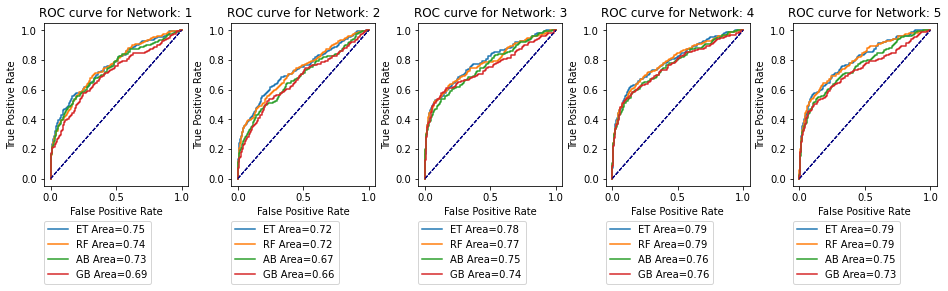

In [63]:
#Creating Figure
fig,axs=plt.subplots(1,len(NETnames),figsize=(16,3))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

#Filling the subplots
for i in range(len(searchMethods)):
    for j in range(len(NETnames)):
        axs[j].plot(valuesROCFromFile[i][j][0,:],
                    valuesROCFromFile[i][j][1,:],
                    label=searchMethods[i]+' Area='+str(tableROCScore.iloc[i,j])[0:4])
        axs[j].set_title('ROC curve for Network: '+str(j+1))
        axs[j].set_ylabel("True Positive Rate")
        axs[j].set_xlabel("False Positive Rate")
        axs[j].legend(loc=(0, -.6), prop=dict(size=10))
        axs[j].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        
fig.savefig(figPathPart1+'ROC_Curve_5NET.jpg', dpi=300, bbox_inches='tight')

#### PR Results

Area under curve values depending on the DREAM4 network

In [55]:
scoresPRFromFile=array([[ auc(valuesPRFromFile[j][i][0,:],valuesPRFromFile[j][i][1,:]) for i in range(len(dataPaths))] for j in range(len(searchMethods))])
tablePRScore=pd.DataFrame(scoresPRFromFile,index=searchMethods,columns=NETnames)

display(tablePRScore)

NET1      NET2      NET3      NET4      NET5
ET  0.137174  0.154357  0.220164  0.190827  0.174472
RF  0.153808  0.152742  0.218177  0.208720  0.195291
AB  0.118425  0.127231  0.207292  0.202043  0.139994
GB  0.117907  0.094273  0.184419  0.170073  0.133148

Curve values depending on the DREAM4 Network

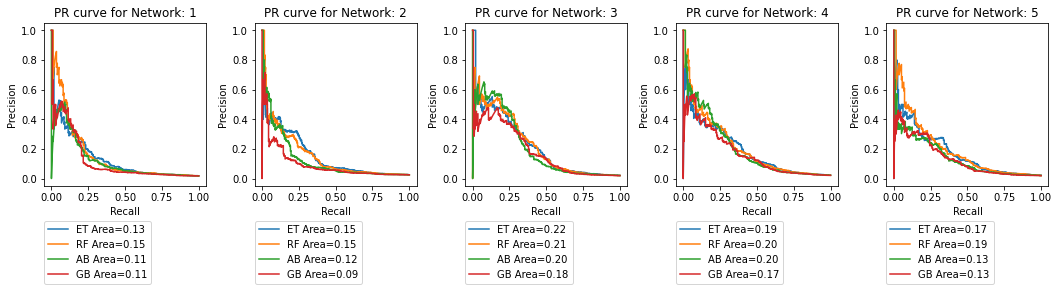

In [64]:
#Creating Figure
fig,axs=plt.subplots(1,len(NETnames),figsize=(18,3))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

#Filling the subplots
for i in range(len(searchMethods)):
    for j in range(len(NETnames)):
        axs[j].plot(valuesPRFromFile[i][j][0,:],
                    valuesPRFromFile[i][j][1,:],
                    label=searchMethods[i]+' Area='+str(tablePRScore.iloc[i,j])[0:4])
        axs[j].set_title('PR curve for Network: '+str(j+1))
        axs[j].set_ylabel("Precision")
        axs[j].set_xlabel("Recall")
        axs[j].legend(loc=(0, -.6), prop=dict(size=10))
        
fig.savefig(figPathPart1+'PR_Curve_5NET.jpg', dpi=300, bbox_inches='tight')

## II) Other algorithms against GENIE3

In [67]:
def ROC_plot(result,label,ax,color):
    fpr, tpr, _ = roc_curve(result["IS_REGULATED"], result["score"])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color,
         lw=2, label='ROC curve of '+label+' (area = %0.2f)' % roc_auc)
    return roc_auc

def PR_plot(result,label,ax,color):
    precision, recall, _ = precision_recall_curve(result["IS_REGULATED"], result["score"])
    average_precision = average_precision_score(result["IS_REGULATED"], result["score"])
    ax.plot(recall, precision, color=color, lw=2,
          label='Precision-Recall curve of '+label+' (area = %0.2f)' % average_precision)
    return average_precision

In [68]:
def goldSTD_(index_fig):
    grn = pd.read_csv("../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_"+\
                    str(index_fig)+".tsv",sep="\t",header=None)

    grn.columns = ["TF","TG","IS_REGULATED"]
    grn.index = grn["TF"]+"_"+grn["TG"]

    grn = grn.drop_duplicates()
    return grn

In [69]:
def load_data(x):
    X = x.T
    tf = X.index.to_numpy()
    X = z_score(X,axis=1)
    return X,tf

In [70]:
def plot_that_bitch(score_matrix_table, index_fig, grn):
    ROC_auc_table = []
    PR_auc_table = []
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    lw = 2

    labels = ['GENIE3', 'AdaBoost', 'BayesianRidgeScore', 'TIGRESS', 'XGENIE3', 'GRNBoost2']
    colors = cm.rainbow(np.linspace(0,1,len(labels)))

    for i in range(len(labels)):
        score_matrix = score_matrix_table[i]
        ranking = rank_GRN(score_matrix)
        result = pd.concat([grn, ranking], axis=1)
        result = result.dropna()
        ROC_auc = ROC_plot(result, labels[i], ax1, colors[i])
        PR_auc = PR_plot(result, labels[i], ax2, colors[i])
        ROC_auc_table.append(ROC_auc)
        PR_auc_table.append(PR_auc)

    ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic example')
    ax1.legend(loc=(0, -.4), prop=dict(size=10))

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(loc=(0, -.4), prop=dict(size=10))

    f.show()
    f.savefig('ROC_PR_Curve'+str(index_fig)+'.jpg', dpi=300, bbox_inches='tight')
    return ROC_auc_table, PR_auc_table

In [71]:
def multi_score(X,tf):
    score_matrix_table = []
    for i in [GENIE3, AdaBoost_regressor, BayesianRidgeScore, TIGRESS, XGENIE3, GRNBoost2]:
        score_matrix_table.append(score_links(X, i, tf))
    return score_matrix_table

In [72]:
import plotly.graph_objects as go

def plot_my_bar(df,title_):
    fig = go.Figure()
    for j in df.columns:
        fig.add_trace(go.Bar(name=j, x=df.index, y=df[j],text = np.round(df[j],3),
                      textposition='auto'))


    fig.update_layout(barmode='group')
    fig.update_layout(
      title=title_,
      yaxis_title="Area under the curve (AUC)",
      #legend_title="Models Name",
      font=dict(
          family="Arial",
          size=18,
          color="Black"
      )
    )

    fig.show()

In [76]:
x1 = pd.read_csv('../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv', sep='\t')
x2 = pd.read_csv('../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_2_multifactorial.tsv', sep='\t')
x3 = pd.read_csv('../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_3_multifactorial.tsv', sep='\t')
x4 = pd.read_csv('../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_4_multifactorial.tsv', sep='\t')
x5 = pd.read_csv('../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_5_multifactorial.tsv', sep='\t')

X_tot = [x1,x2,x3,x4,x5]

print(X_tot)

[          G1        G2        G3        G4        G5        G6        G7  \
0   0.260809  0.377312  0.493373  0.182896  0.472203  0.440406  0.613081   
1   0.274420  0.333810  0.385739  0.058213  0.643646  0.345810  0.411500   
2   0.174974  0.313279  0.435140  0.153795  0.210283  0.163809  0.528071   
3   0.057877  0.415606  0.556997  0.057077  0.360422  0.365259  0.638240   
4   0.056687  0.501247  0.657297  0.061193  0.099516  0.159289  0.619199   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.070287  0.146432  0.255137  0.096892  0.185204  0.278635  0.551643   
96  0.117101  0.299167  0.417338  0.189524  0.281403  0.445769  0.065613   
97  0.048834  0.309620  0.489881  0.086354  0.442000  0.475054  0.662047   
98  0.064282  0.388008  0.447046  0.165093  0.382012  0.315885  0.485404   
99  0.124599  0.190915  0.302397  0.101481  0.141994  0.337656  0.554702   

          G8        G9       G10  ...       G91       G92       G93       G94  \
0   0

# Run all models
This cell is going to blow your shit up!!!   
But also display nice result curves

In [89]:
#Getting Gene names
f = open('../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv')
gene_names = f.readline()
gene_names = gene_names.rstrip('\n').split('\t')
gene_names = ' '.join(gene_names).replace('"','').split()
f.close()

['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 'G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27', 'G28', 'G29', 'G30', 'G31', 'G32', 'G33', 'G34', 'G35', 'G36', 'G37', 'G38', 'G39', 'G40', 'G41', 'G42', 'G43', 'G44', 'G45', 'G46', 'G47', 'G48', 'G49', 'G50', 'G51', 'G52', 'G53', 'G54', 'G55', 'G56', 'G57', 'G58', 'G59', 'G60', 'G61', 'G62', 'G63', 'G64', 'G65', 'G66', 'G67', 'G68', 'G69', 'G70', 'G71', 'G72', 'G73', 'G74', 'G75', 'G76', 'G77', 'G78', 'G79', 'G80', 'G81', 'G82', 'G83', 'G84', 'G85', 'G86', 'G87', 'G88', 'G89', 'G90', 'G91', 'G92', 'G93', 'G94', 'G95', 'G96', 'G97', 'G98', 'G99', 'G100']


In [78]:
index_fig=1
roc_df = pd.DataFrame(columns=['GENIE3', 'AdaBoost', 'BayesianRidgeScore', 'TIGRESS', 'XGENIE3', 'GRNBoost2'])
pr_df = pd.DataFrame(columns=['GENIE3', 'AdaBoost', 'BayesianRidgeScore', 'TIGRESS', 'XGENIE3', 'GRNBoost2'])

print(gene_names)
for i in X_tot:
    X,tf = load_data(i)
    print(X)
    print(tf)
    """
    score_matrix_table = multi_score(X,tf)
    grn = goldSTD_(index_fig)
    ROC_auc_table, PR_auc_table = plot_that_bitch(score_matrix_table, index_fig, grn)
    roc_df.loc[index_fig]=ROC_auc_table
    pr_df.loc[index_fig]=PR_auc_table
    index_fig+=1
"""

['"G1"', '"G2"', '"G3"', '"G4"', '"G5"', '"G6"', '"G7"', '"G8"', '"G9"', '"G10"']
            0         1         2         3         4         5         6   \
G1   -0.007557  0.088317 -0.612162 -1.436984 -1.445366 -0.720309 -1.481921   
G2    0.796355  0.434994  0.264445  1.114462  1.825865  0.004682  0.776230   
G3    0.792609 -0.182097  0.265263  1.368770  2.277060 -0.443655 -0.327737   
G4    1.399583 -0.874894  0.868720 -0.895601 -0.820528  0.473843 -0.437235   
G5    0.508863  1.665419 -1.258053 -0.245217 -2.005289 -2.491798  0.238396   
...        ...       ...       ...       ...       ...       ...       ...   
G96  -1.249704 -0.818236 -0.915960  0.302817 -0.896489 -0.814163  0.911150   
G97   1.072007 -1.022930 -0.513362 -0.245064 -0.500595 -0.882604  1.481519   
G98   1.121697  0.871785  0.441748  0.062467 -0.436526 -0.753998  0.130490   
G99   0.079314 -0.437249  0.028310 -0.524299 -0.565273 -0.410712 -0.181597   
G100  0.124072 -0.912938  0.362601  1.616185  0.478010 -0.96

## Plot AUC Bars
But once you have done the compute, you can plot those nice BARS

In [74]:
plot_my_bar(roc_df, 'AUC of the ROC curves for different models')
plot_my_bar(pr_df, 'AUC of the PR curves for different models')

NameError: name 'roc_df' is not defined

In [ ]:
#Plotting a Graph
data=loadtxt(data_1,skiprows=1)
VIM=GENIE3(data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1)
print(VIM)
conn_indices = where(VIM) 
weights = VIM[conn_indices]
edges = zip(*conn_indices)
g=igraph.Graph(directed=True,edges=edges)
g.es['weight']=VIM
g.es["width"]=weights * 4
g.vs['label']=gene_names

In [26]:
igraph.plot(g,labels=True,margin=80)